In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import analysis # enable import from model folder
from bmtool.util import util
from bmtk.simulator import bionet

from build_input import get_populations, get_stim_cycle, t_start, on_time, off_time
import plot

TRIAL_NAME = "short_test_22"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

In [2]:
isbaseline = 'baseline' in TRIAL_NAME
if isbaseline:
    config_file = 'config.json'
else:
    config_file = 'config_short.json' if 'short' in TRIAL_NAME else 'config_long.json'

spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
config_file = os.path.join('..', 'M1Focus', config_file)

pop_color = plot.pop_color
pop_names = plot.pop_names

### Spike Raster

In [3]:
conf = bionet.Config.from_json(config_file)
t_stop = conf['run']['tstop'] / 1000

nodes = util.load_nodes_from_config(config_file)
network_name = 'cortex'
cortex_df = nodes[network_name]

with h5py.File(spike_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })
    spikes_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

In [4]:
if not isbaseline:
    t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)
    window = t_start + np.array([[0, on_time]])
    windows = (window + t_cycle * np.arange(n_cycle).reshape(n_cycle, 1))
else:
    windows = np.array([[0., t_stop]])

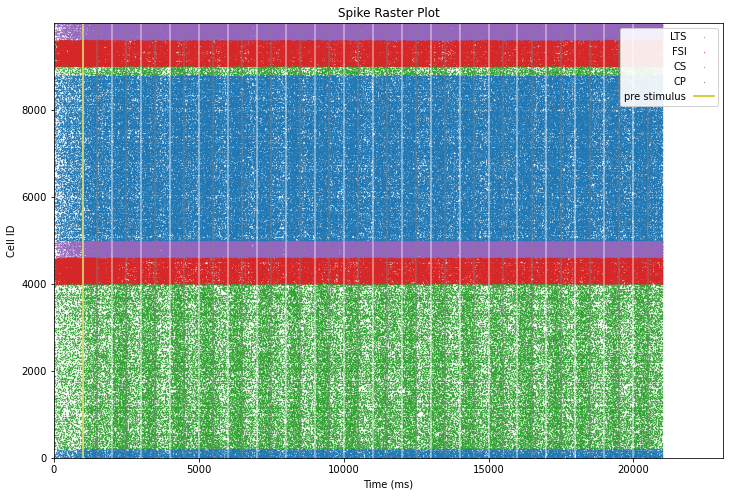

In [5]:
spikes_df['pop_name'] = cortex_df.loc[spikes_df['node_ids'], 'pop_name'].values
pop_spike = get_populations(spikes_df, pop_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot.raster(pop_spike, pop_color, ax=ax)
plt.axvline(t_start * 1000, color='y', label='pre stimulus')
if not isbaseline:
    for win in windows:
        plt.axvline(win[0] * 1000, color='white', alpha=0.5)
        plt.axvline(win[1] * 1000, color='gray', alpha=0.5)
plt.legend(loc='upper right', framealpha=0.9, markerfirst=False)
plt.xlim([0, 1.1 * spikes_df['timestamps'].max()])
plt.ylim([cortex_df.index.min(), cortex_df.index.max()])
plt.show()

### Firing Rate

In [6]:
frs = plot.firing_rate(spikes_df, num_cells=len(cortex_df), time_windows=windows)
Cortex_nodes = get_populations(cortex_df, pop_names, only_id=True)
pop_fr = {p: frs[nid] for p, nid in Cortex_nodes.items()}

if not isbaseline:
    print('Stimulus on time: ')

print('Firing rate: mean, std')
for p, fr in pop_fr.items():
    print(f'{p}: {fr.mean():.3g}, {fr.std():.3g}')

Stimulus on time: 
Firing rate: mean, std
CP: 2.96, 2.06
CS: 1.59, 1.22
FSI: 4.87, 3.96
LTS: 10.5, 5.5


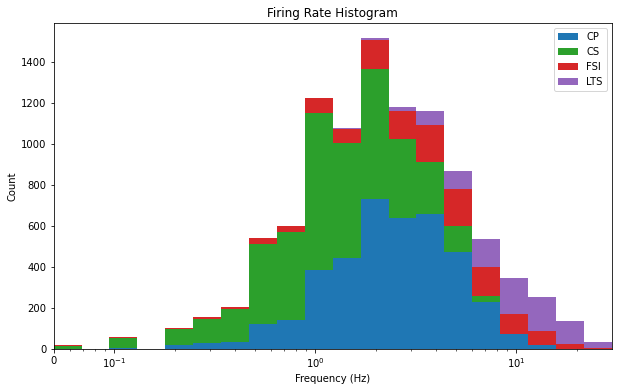

In [7]:
min_fr = 0.5 / plot.total_duration(windows)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot.firing_rate_histogram(pop_fr, pop_color, bins=20, min_fr=min_fr,
                      logscale=True, stacked=True, ax=ax)
plt.show()

### Calling plot functions directly

Plotting cortex spike raster


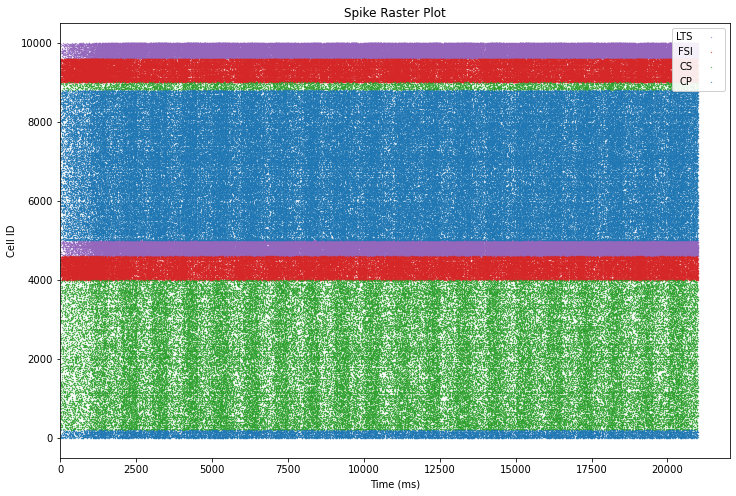

On average: 
Firing rate: mean, std
CP: 2.6, 1.87
CS: 1.29, 1.08
FSI: 4.68, 3.47
LTS: 8.63, 4.59
Plotting firing rates


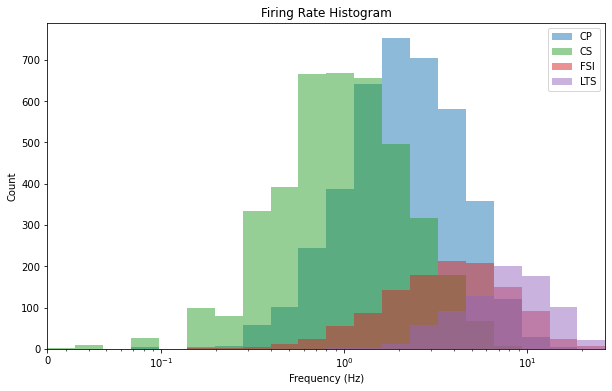

In [8]:
pop_spike = plot.plot(choose=1, spike_file=spike_file, config=config_file, figsize=(12, 8))

if not isbaseline:
    print('On average: ')
frs = plot.plot(choose=2, spike_file=spike_file, figsize=(10, 6))